In [3]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import os
import glob, cv2, time, math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3, VGG19
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore") 

## Deep Neural Network with Dropout & L2 Regularization & ADAM Optimizer

In [2]:
def parameters_initialization(layers):
    
    """
    To Initialize Parameters in Deep Neural Network
    
    Arguments : 
    
        layers: How many layers in the DNN model
        
    Returns   :
    
        Parameters
    """
    np.random.seed(3)
    parameter = {}
    len_layers = len(layers)
    for l in range(1,len_layers):
        parameter["W"+str(l)] = np.random.randn(layers[l],layers[l-1])*np.sqrt(2/layers[l-1])
        parameter["b"+str(l)] = np.zeros((layers[l],1))
    return parameter

def initialize_adam(parameters) :
    
    """
    To Initialize Parameters v and s for ADAM Optimizer
    
    Arguments : 
    
        parameters : all parameters in model
        
    Returns   :
    
        v : ADAM Parameters
        s : ADAM Parameters
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
    
        v["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    To update all parameters in model
    
    Arguments : 
    
        parameters : all parameters in model
        grads : gradient of parameters
        v : ADAM parameters
        s : ADAM parameters
        t : Current layer
        learning_rate : learning rate
        beta1 : ADAM beta parameter 
        beta2 : ADAM beta parameter
        epsilon : epsilon
        
    Returns   :
    
        v : ADAM Parameters
        s : ADAM Parameters
    """
    
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW" + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db" + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)
        
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*(grads["dW" + str(l)])**2
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*(grads["db" + str(l)])**2

        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-beta2**t)

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*(v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)])+epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*(v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)])+epsilon))

    return parameters, v, s, v_corrected, s_corrected

def sigmoid(Z):
    
    """
    Activation Function where the value lies between (0,1) interval.
    
    Arguments :
    
        Z     : Linear value
        
    Returns   :
        
        val   : the output of Sigmoid function
        Z     : Linear value
        
    """
    val = 1./(1. + np.exp(-Z))
    return val, (val,Z)

def relu(Z):
    
    """
    Activation Function where the value lies between [0,inf) interval.
    
    Arguments :
    
        Z     : Linear value
        
    Returns   :
        
        val   : the output of Relu function
        Z     : Linear value
        
    """
    val = np.maximum(0.0,Z)
    return val, (val,Z)

def sigmoid_backward(AL, Y, cache):
    
    """
    To compute derivative of Sigmoid function
    
    Arguments :
    
        Al    : Linear value
        Y     : Actual prediction
        cahce : contains (Z)
        
    Returns   :
        
        dZ   : the output of derivative
    """
    Z = cache[1]
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    
    """
    To compute derivative of Sigmoid function
    
    Arguments :
    
        dA    : Previous value of dA
        cahce : contains (A, Z)
        
    Returns   :
        
        dZ  : the output of derivative
    """
    A = cache[0]
    Z = cache[1]
    dZ = np.multiply(dA, np.int64(A > 0))
    assert (dZ.shape == Z.shape)
    return  dZ

def back_prop_linear(dZ, caches):
    """
    To compute 
    
    Arguments :
    
        dA    : Previous value of dA
        cahce : contains (A, Z)
        
    Returns   :
        
        dZ  : the output of derivative
    """
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = 1./m * (np.dot(dZ, A_prev.T))
    db = 1./m * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def forward_prop_linear(A_prev, W, b):
    
    """"
    To compute linear function (Z)
    
    Arguments :
    
        A_prev   : Previous value of A
        W : W parameters
        b : b parameters
        
    Returns   :
        
        Z  : the output of lineas function
        caches : (A_prev, W, b)
    """
    Z = np.dot(W,A_prev) + b
    caches = (A_prev, W, b)
    return Z, caches

def forward_prop_activation(A_prev, W, b, activation):
    
    """"
    To compute Activation function 
    
    Arguments :
    
        A_prev   : Previous value of A
        W : W parameters
        b : b parameters
        activation : 'relu' or 'sigmoid'
        
    Returns   :
        
        A : the output of activation function
        caches : (linear caches, activation caches)
    """
    
    if activation == "sigmoid":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = relu(Z)
    caches = (linear_caches,activation_caches)
    return A , caches

def L_forward_prop(X, parameters):
    
    """"
    To compute prediction values
    
    Arguments :
    
        X : X values
        parameters : parameters
        
    Returns   :
        
        AL : prediction values
        caches : (linear caches, activation caches)
    """
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def L_forward_prop_dropout(X, parameters, keep_prob):
    
    """"
    To compute prediction values
    
    Arguments :
    
        X : X values
        parameters : parameters
        keep_prob : [0,1] values
        
    Returns   :
        
        AL : prediction values
        caches : (linear caches, activation caches)
    """
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        D = np.random.rand(A.shape[0],A.shape[1])
        D = (D <= keep_prob).astype('int64')
        A = np.multiply(A,D)/keep_prob
        cache = cache + (D,)
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def back_prop_linear_with_regularization(dZ, caches, lambd):
    
    """"
    To compute dA values
    
    Arguments :
    
        dZ : derivative of Z
        caches : (A_prev, W, b)
        lambd : Regularization value
        
    Returns   :
        
        dA_prev : derivative of A
        d_W : derivative of W
        d_b : derivative of b
    """
    
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = (1./m) * (np.dot(dZ, A_prev.T)) + (lambd/m)*W 
    db = (1./m) * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def back_prop_activation_with_regularization_dropout(dA, Y, cache, lambd, activation):
    
    """"
    To compute dA values
    
    Arguments :
    
        dZ : derivative of Z
        caches : (A_prev, W, b)
        lambd : Regularization value
        
    Returns   :
        
        dA_prev : derivative of A
        d_W : derivative of W
        d_b : derivative of b
    """
    
    if activation == "sigmoid":
        linear_cache, activation_cache = cache
        dZ  = sigmoid_backward(dA, Y, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    elif activation == "relu":
        linear_cache, activation_cache, D = cache
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    return dA_prev, dW, db

def L_back_prob_with_regularization_dropout(Y, AL, lambd, caches, keep_prob):
    
    """"
    To compute all parameters gradient
    
    Arguments :
    
        Y : Actual values
        Al : Prediction values
        lambd : Regularization value
        caches : (linear caches, activation caches)
        keep_prob : [0,1] values
        
    Returns   :
        
        grads : gradient of all parameters
    """
    
    
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    Y = Y.reshape(AL.shape)

    current_cache = caches[L-1]
    d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization_dropout(AL, Y, current_cache, lambd, activation = "sigmoid")
    grads["dA"+ str(L-1)] = d_A_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for i in  reversed(range(L-1)):
        current_cache = caches[i]
        grads["dA"+ str(i+1)] = np.multiply(grads["dA"+ str(i+1)], current_cache[-1])/keep_prob
        d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization_dropout(grads["dA"+ str(i+1)],Y, current_cache, lambd, activation = "relu")
        grads["dA"+ str(i)] = d_A_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp
        
    return grads

def compute_cost_with_regularization(AL, Y, parameters,  lambd):
    
    """"
    To compute cost
    
    Arguments :
    
        Y : Actual values
        Al : Prediction values
        parameters : parameters
        lambd : Regularization value
        
    Returns   :
        
        cost :cost
    """
    
    
    m = Y.shape[1]
    n_params = len(parameters) // 2
    cost_original = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))
    L2_sum = 0
    
    for l in range(1, n_params + 1):
        L2_sum += np.sum(np.square(parameters["W" + str(l)]))
        
    L2_cost = (lambd/(2.*m))*L2_sum
    
    cost = cost_original + L2_cost
    return cost


def L_layer_model_with_regularization_adam(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0075, lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_iterations = 3000, keep_prob = 1,  print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X : data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y : true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims : list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate : learning rate of the gradient descent update rule
    num_iterations : number of iterations of the optimization loop
    keep_prob : [0,1] value
    print_cost : if True, it prints the cost every 100 steps
    
    Returns:
    parameters : parameters learnt by the model. They can then be used to predict.
    grads : gradient of model
    cost : cost of model
    train_acc : training accuracy
    test_acc : testing accuracy

    """

    np.random.seed(1)
    costs = []          # keep track of cost
    train_acc = []
    test_acc = []
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)
    v, s = initialize_adam(parameters)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_forward_prop_dropout(X_train, parameters, keep_prob)
        
        # Compute cost.
        cost = compute_cost_with_regularization(AL, Y_train, parameters,  lambd)
        costs.append(cost)
    
        # Backward propagation.
        grads = L_back_prob_with_regularization_dropout(Y_train, AL, lambd, caches, keep_prob)
 
        # Update parameters.
        parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, i+1, learning_rate , beta1, beta2, epsilon)
        
        # Accuracy Checking.
        
        y_pred_train, caches_train = L_forward_prop(X_train, parameters)
        y_pred_test, caches_test = L_forward_prop(X_test, parameters)
        
        train_acc.append(accuracy_score(Y_train,y_pred_train))
        test_acc.append(accuracy_score(Y_test,y_pred_test))
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, grads, costs, train_acc, test_acc

def plot_costs(costs, learning_rate=0.0075):
    
    """"
    To draw plot of cost
    
    Arguments :
        
        cost : cost
        learing_rate : learning rate
        
    Returns   :
        
        cost plot
    """
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
def accuracy_score(y_true, y_pred):
    """"
    To calculate an accuracy score
    
    Arguments :
        
        y_true : Actual value
        y_test : Prediction value
        
    Returns   :
        
        accuracy : accuracy
    """
    y_true = np.squeeze(y_true)
    y_pred = np.round(np.squeeze(y_pred)).astype("int64")
    m = len(y_pred)
    correct = len(y_pred[y_pred == y_true])
    accuracy = correct/m
    return accuracy

In [ ]:
# Create data from sklearn library.

X, y = make_classification(n_samples = 100000, n_features = 15, n_informative = 10, n_redundant = 2, n_classes = 2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.20,  random_state = 42)

In [ ]:
print("Proportion of classes in training data :")
print(f"Class '1' : {np.round(np.mean(y_train),2)}")
print(f"Class '0' : {1 - np.round(np.mean(y_train),2)}")
print("Proportion of classes in testing data :")
print(f"Class '1' : {np.round(np.mean(y_test),2)}")
print(f"Class '0' : {1 - np.round(np.mean(y_test),2)}")

In [ ]:
# Create classification model
rf = RandomForestClassifier(n_jobs = -1, random_state = 42)
cv_score = np.mean(cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10, scoring = 'accuracy', n_jobs = -1))
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test,y_pred)

In [ ]:
# Feature importance visualizaition.

important_features = rf.feature_importances_
sorted_idx = np.argsort(important_features)
sorted_important_features = important_features[sorted_idx]
sorted_label_features = np.array([f"Feauture - {i}" for i in range(1,16)])[sorted_idx]

fig, ax = plt.subplots(figsize = (7,9))
ax.barh( y = np.arange(1,16) , width = sorted_important_features)
ax.set_yticks(np.arange(1,16))
ax.set_yticklabels(sorted_label_features)
ax.set_title("Features Important")
plt.show()

In [ ]:
## Classification report.

print("Classification report for Random Forest :")
print(report)
print("Cross validation score :")
print(cv_score)

In [ ]:
# Hyperparameter Tuning.

params = {"n_estimators"    : np.arange(100,501, 100),
         "criterion"        : ["gini","entropy"]}

gs_cv = GridSearchCV(estimator = rf, param_grid = params, scoring = 'accuracy',
                    cv = 10, n_jobs = -1).fit(X_train,y_train)

y_pred = gs_cv.predict(X_test)
best_parameters = gs_cv.best_params_
report = classification_report(y_test,y_pred)

In [ ]:
print("Best Parameter :")
print(best_parameters)
print("Report :")
print(report)

In [ ]:
## Preprocessing data before applied to Deep Neural Network Model/

X_train_tf = X_train.T
X_test_tf = X_test.T
y_train_tf = y_train.reshape(1,-1)
y_test_tf = y_test.reshape(1,-1)

print("Training Data Shape :")
print(f"X = {X_train_tf.shape}")
print(f"Y = {y_train_tf.shape}")
print("Testing Data Shape :")
print(f"X = {X_test_tf.shape}")
print(f"Y = {y_test_tf.shape}")

In [ ]:
## Create Deep Neural Network Model

layers = [15, 250, 100, 125, 50, 25, 5, 1] # 10 layers
parameters, grads, costs, train_acc, test_acc =  L_layer_model_with_regularization_adam(X_train_tf, y_train_tf, X_test_tf, y_test_tf, layers, learning_rate = 0.00005, 
                                                                                        lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-7, num_iterations = 2000, keep_prob = 1,  print_cost = True)

In [ ]:
## Cost function visualization.

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(costs)+1), costs, label = 'Cost')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")
ax.legend()
plt.show()

In [ ]:
## Accuracy visualization.

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(train_acc)+1), train_acc, label = 'Train accuracy')
ax.plot(np.arange(1,len(test_acc)+1), test_acc, label = 'Test accuracy')
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy Score")
ax.legend()
plt.show()

In [ ]:
## Classification report.

y_pred , _ = L_forward_prop(X_test_tf, parameters)
y_pred = np.round(np.squeeze(y_pred)).astype(int)
report = classification_report(y_test,y_pred)
print(report)

## Image Recognition With CNN

In [4]:
# Load Imanges From Directory.

training_dir = "C:/Users/naufa/Car-Bike-Dataset/Training"
validation_dir = "C:/Users/naufa/Car-Bike-Dataset/Validation"
testing_dir = "C:/Users/naufa/Car-Bike-Dataset/Testing"

training_gen = ImageDataGenerator(rescale = 1/255)
training_img = training_gen.flow_from_directory(directory  = training_dir, target_size = (250,250), batch_size = 50,
                                               class_mode = 'binary', shuffle = False)

validation_gen = ImageDataGenerator(rescale = 1/255)
validation_img = validation_gen.flow_from_directory(directory = validation_dir, target_size = (250,250), batch_size = 25,
                                                   class_mode = 'binary', shuffle = False)

Found 4000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [5]:
img_train, labels_train = training_img.next()
print(img_train.shape)
print(labels_train.shape)

(50, 250, 250, 3)
(50,)


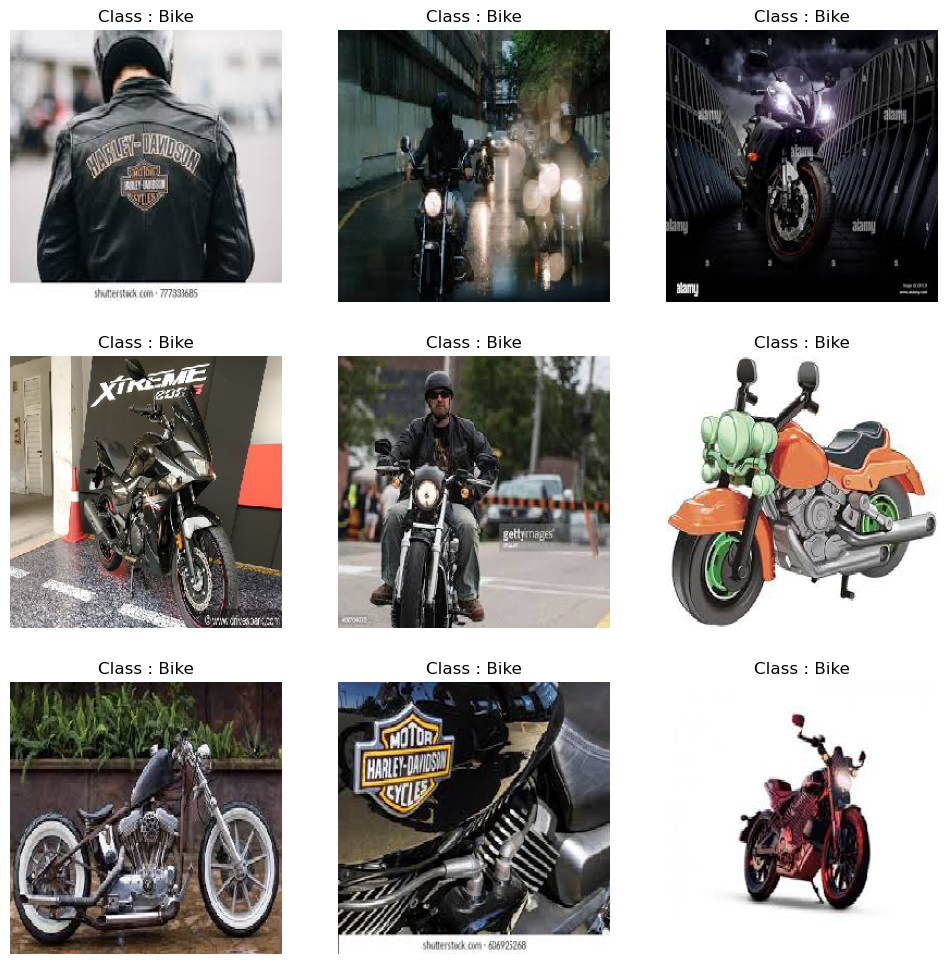

In [6]:
## Take 9 image samples from training images.

categories = ["Bike","Car"]
img_train, labels_train = training_img.next()

n_rows = 3
n_cols = 3

fig = plt.gcf()
fig.set_size_inches(n_cols*4, n_rows*4)

for i, img in enumerate(img_train[:9]):
    
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off') 
    plt.title(f"Class : {categories[labels_train[i].astype('uint8')]}")
    plt.imshow(img)



##  CNN With Tensorflow For Image Classification

In [7]:
## Create Class For CallBacks.

class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
            print("\nReached 98.0 % accuracy so cancelling training!")
            self.model.stop_training = True

In [8]:
## Define Hyperparameters.

learning_rate = 0.001
epoch = 20
callbacks = MyCallBack()

In [9]:
## Define dictionary for dataframe.

report_df = {
    "Model" : [],
    "Validation Accuracy" : [],
    "Testing Accuracy" : [],
    "Time" : []
}

## LeNet50 CNN Architecture 

In [10]:
## Create  Model's Layers.

model_1 = keras.Sequential([
    keras.layers.Conv2D(6, (5,5), activation = 'tanh', strides = 1, input_shape = (250,250,3)),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Conv2D(16, (5,5), activation = 'tanh', strides = 1),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'tanh'),
    keras.layers.Dense(84, activation = 'tanh'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [11]:
## Compile and Print the summary of the model.

model_1.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate), 
                loss = 'binary_crossentropy',
                metrics= ["accuracy"])
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 123, 123, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 59, 59, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 55696)             0         
                                                                 
 dense (Dense)               (None, 120)               6

In [12]:
## Model Fitting.
start = time.time()
history = model_1.fit(x = training_img, epochs = epoch, callbacks = [callbacks], validation_data = validation_img)
end = time.time()
wait_time = np.round((end-start),2)

Epoch 1/20
80/80 [==============================] - 34s 420ms/step - loss: 0.9614 - accuracy: 0.4995 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 2/20
80/80 [==============================] - 34s 423ms/step - loss: 0.7268 - accuracy: 0.4875 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/20
80/80 [==============================] - 34s 425ms/step - loss: 0.7404 - accuracy: 0.4875 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 4/20
80/80 [==============================] - 34s 429ms/step - loss: 0.7054 - accuracy: 0.4500 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/20
80/80 [==============================] - 35s 440ms/step - loss: 0.7069 - accuracy: 0.3750 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 6/20
80/80 [==============================] - 36s 455ms/step - loss: 0.7132 - accuracy: 0.4375 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 7/20
80/80 [==============================] - 37s 462ms/step - loss: 0.7017 - accuracy: 0.4625 - val_loss: 0.7134 - val_accuracy: 0.5000

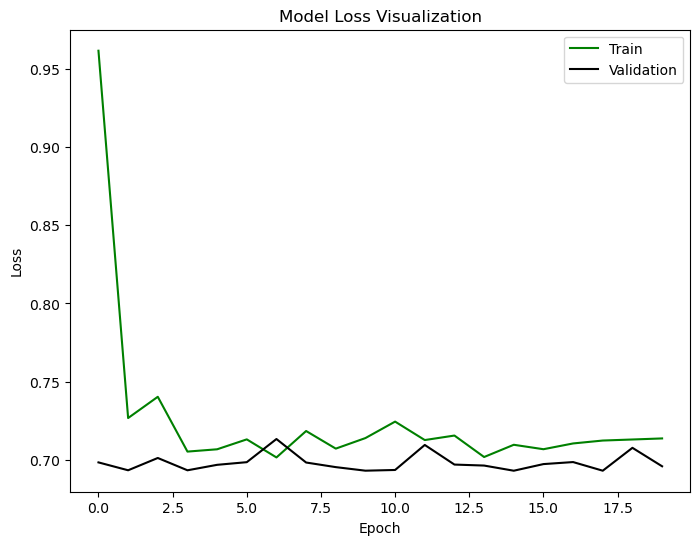

In [18]:
## loss Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

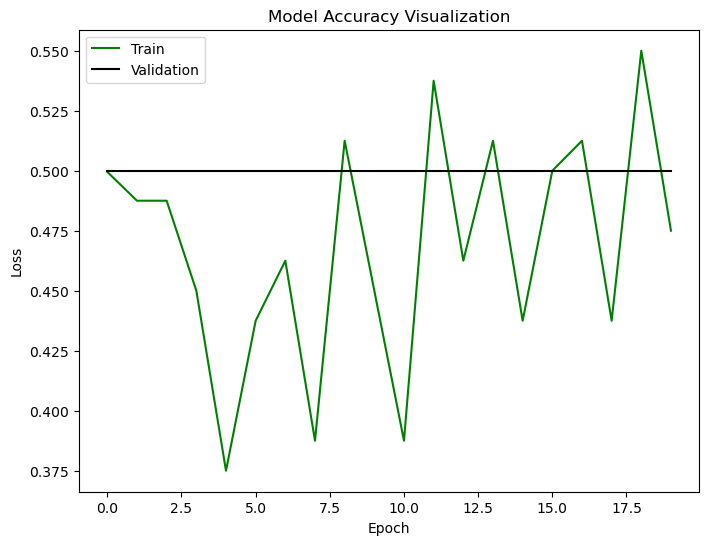

In [19]:
## Accuracy Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [20]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

16/16 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



In [21]:
## Model on Testing Data.

testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 30 images belonging to 2 classes.
1/1 [==============================] - 0s 91ms/step
Classification report :

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



In [22]:
val_acc_score_model_1 = np.round(history.history['val_accuracy'][-1],2)
test_acc_score_model_1 = accuracy_score(test_labels, test_pred)

## Inserting data to dictionary.

report_df["Model"].append("LeNet-50")
report_df["Validation Accuracy"].append(val_acc_score_model_1)
report_df["Testing Accuracy"].append(test_acc_score_model_1)
report_df["Time"].append(wait_time)

## AlexNet CNN Architecture

In [23]:
## Create model's layers.

model_2 = keras.Sequential([
    keras.layers.Conv2D(96, (11,11), strides = 4, activation = 'relu', input_shape = (250,250,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(256, (5,5), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(384, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.Conv2D(384, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.Conv2D(256, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [24]:
## Compile and print the summary of the model.

model_2.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy',
                metrics= ["accuracy"])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 96)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 256)      1024      
 hNormalization)                                                 
                                                      

In [25]:
## Model fitting.
start = time.time()
history = model_2.fit(x = training_img, epochs = epoch, validation_data = validation_img, callbacks = [callbacks])
end = time.time()
wait_time = np.round((end-start),2)

Epoch 1/20
80/80 [==============================] - 42s 504ms/step - loss: 4.6913 - accuracy: 0.4565 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
80/80 [==============================] - 43s 541ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
80/80 [==============================] - 46s 581ms/step - loss: 0.6933 - accuracy: 0.3995 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
80/80 [==============================] - 47s 585ms/step - loss: 0.6933 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
80/80 [==============================] - 47s 585ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
80/80 [==============================] - 47s 586ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
80/80 [==============================] - 47s 592ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000

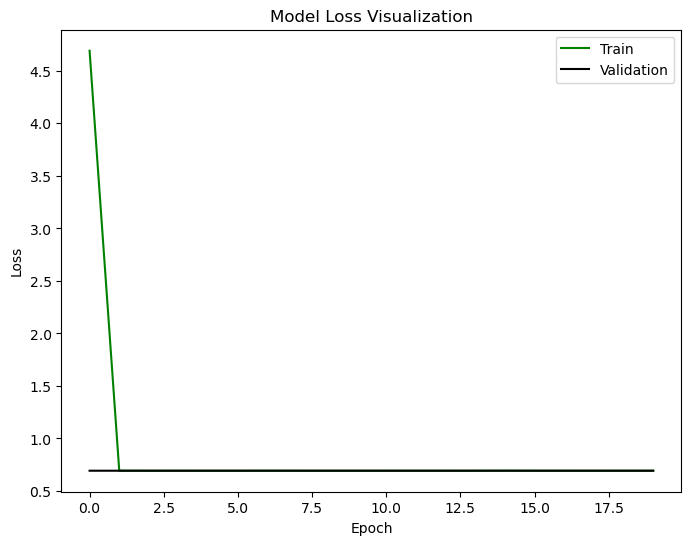

In [29]:
## Loss visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

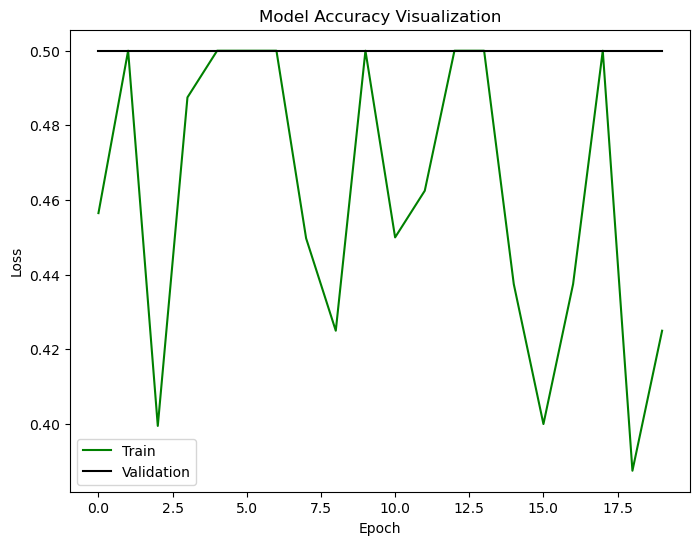

In [30]:
## Accuracy visualization

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [31]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

16/16 [==============================] - 1s 56ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



In [32]:
## Model on Testing Data.

testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 30 images belonging to 2 classes.
1/1 [==============================] - 0s 106ms/step
Classification report :

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



In [33]:
val_acc_score_model_2 = np.round(history.history['val_accuracy'][-1],2)
test_acc_score_model_2 = accuracy_score(test_labels, test_pred)

## Inserting data to dictionary.

report_df["Model"].append("AlexNet")
report_df["Validation Accuracy"].append(val_acc_score_model_2)
report_df["Testing Accuracy"].append(test_acc_score_model_2)
report_df["Time"].append(wait_time)

## Transfer Learning With ResNet50

In [34]:
## Create model's layers.

model_3 = tf.keras.Sequential()
base_model = ResNet50(include_top = False, weights = 'imagenet', pooling = "max", input_shape = (250,250,3))
for layer in base_model.layers:
    layer.trainable = False
model_3.add(base_model)
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(64, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [35]:
## Compile and print the summary of the model.

model_3.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy',
                metrics = 'accuracy')
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 128)              

In [36]:
## Model Fitting
start = time.time()
history = model_3.fit(x = training_img, validation_data = validation_img, epochs = epoch,
                     callbacks = [callbacks])
end = time.time()
wait_time = np.round((end-start),2)

Epoch 1/20
80/80 [==============================] - 125s 2s/step - loss: 1.1658 - accuracy: 0.5030 - val_loss: 0.6782 - val_accuracy: 0.5575
Epoch 2/20
80/80 [==============================] - 132s 2s/step - loss: 0.6476 - accuracy: 0.6338 - val_loss: 0.6769 - val_accuracy: 0.6650
Epoch 3/20
80/80 [==============================] - 132s 2s/step - loss: 0.6014 - accuracy: 0.7065 - val_loss: 0.8386 - val_accuracy: 0.6200
Epoch 4/20
80/80 [==============================] - 135s 2s/step - loss: 0.5822 - accuracy: 0.7040 - val_loss: 0.5371 - val_accuracy: 0.7300
Epoch 5/20
80/80 [==============================] - 135s 2s/step - loss: 0.5250 - accuracy: 0.7600 - val_loss: 0.6593 - val_accuracy: 0.6075
Epoch 6/20
80/80 [==============================] - 135s 2s/step - loss: 0.5025 - accuracy: 0.7580 - val_loss: 0.5048 - val_accuracy: 0.7400
Epoch 7/20
80/80 [==============================] - 134s 2s/step - loss: 0.4769 - accuracy: 0.7840 - val_loss: 0.5935 - val_accuracy: 0.7100
Epoch 8/20
80

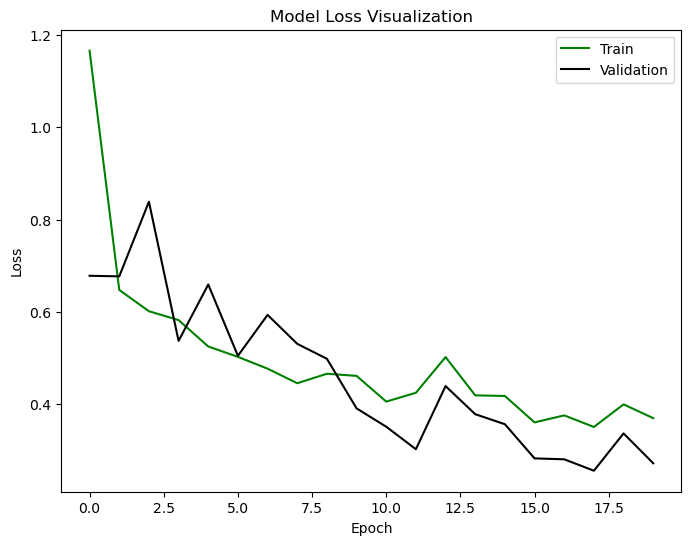

In [37]:
## Loss Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

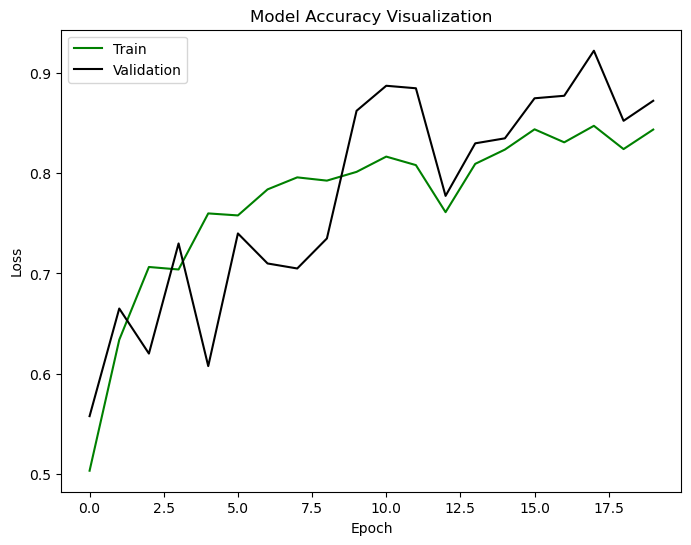

In [38]:
## Accuracy Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [39]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

16/16 [==============================] - 14s 834ms/step
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       200
           1       0.81      0.97      0.88       200

    accuracy                           0.87       400
   macro avg       0.89      0.87      0.87       400
weighted avg       0.89      0.87      0.87       400



In [40]:
## Model on Testing Data.

testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 30 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Classification report :

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.80      0.89        15

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30



In [41]:
val_acc_score_model_3 = np.round(history.history['val_accuracy'][-1],2)
test_acc_score_model_3 = accuracy_score(test_labels, test_pred)

## Inserting data to dictionary.

report_df["Model"].append("ResNet-50")
report_df["Validation Accuracy"].append(val_acc_score_model_3)
report_df["Testing Accuracy"].append(test_acc_score_model_3)
report_df["Time"].append(wait_time)

## Transfer Learning With Inception V3

In [42]:
## Create model's layers.

pre_trained_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (250,250,3))
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
layer_ = tf.keras.layers.Flatten()(last_output)
layer_ = tf.keras.layers.Dense(512, activation = 'relu')(layer_)
layer_ = tf.keras.layers.Dense(256, activation = 'relu')(layer_)
layer_ = tf.keras.layers.Dropout(0.5)(layer_)
layer_ = tf.keras.layers.Dense(1, activation = 'sigmoid')(layer_)

model_4 = tf.keras.Model(pre_trained_model.input, layer_)


In [43]:
## Compile and print the summary of the model.

model_4.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', 
                metrics = 'accuracy')
print(model_4.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 124, 124, 32  96         ['conv2d_7[0][0]']               
 rmalization)                   )                                                             

 batch_normalization_7 (BatchNo  (None, 28, 28, 64)  192         ['conv2d_12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 28, 28, 64)  192         ['conv2d_14[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_12 (BatchN  (None, 28, 28, 96)  288         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_13 (BatchN  (None, 28, 28, 32)  96          ['conv2d_18[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_24 (BatchN  (None, 28, 28, 64)  192         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 28, 28, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 28, 28, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 13, 13, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 13, 13, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_41 (Conv2D)             (None, 13, 13, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 13, 13, 128)  384        ['conv2d_41[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_51 (Conv2D)             (None, 13, 13, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_46 (BatchN  (None, 13, 13, 160)  480        ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 13, 13, 160)  0           ['batch_normalization_46[0][0]'] 
                                                                                                  
 conv2d_52 (Conv2D)             (None, 13, 13, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 13, 13, 160)  0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 conv2d_62 (Conv2D)             (None, 13, 13, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (None, 13, 13, 160)  480        ['conv2d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 13, 13, 160)  0           ['batch_normalization_57[0][0]'] 
          

                                                                                                  
 batch_normalization_67 (BatchN  (None, 13, 13, 192)  576        ['conv2d_72[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 13, 13, 192)  0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 conv2d_68 (Conv2D)             (None, 13, 13, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 13, 13, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

None


In [44]:
## Model fitting.
start = time.time()
history = model_4.fit(x = training_img, validation_data = validation_img, epochs = epoch, callbacks = [callbacks])
end = time.time()
wait_time = np.round((end-start), 2)

Epoch 1/20
80/80 [==============================] - 70s 862ms/step - loss: 3.0161 - accuracy: 0.8310 - val_loss: 0.0341 - val_accuracy: 0.9850
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9940
Reached 98.0 % accuracy so cancelling training!
80/80 [==============================] - 62s 777ms/step - loss: 0.0251 - accuracy: 0.9940 - val_loss: 0.0109 - val_accuracy: 0.9925


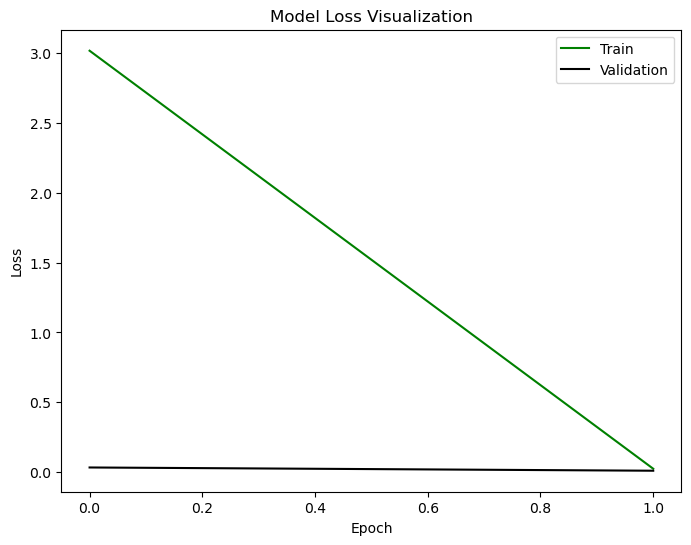

In [45]:
# Loss Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

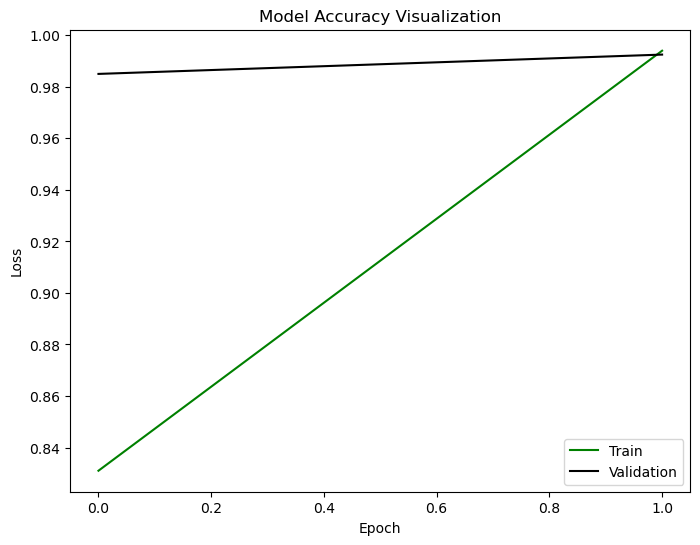

In [46]:
# Accuracy Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [47]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

16/16 [==============================] - 6s 349ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.99      1.00      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [48]:
## Model on Testing Data.


testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 30 images belonging to 2 classes.
1/1 [==============================] - 0s 429ms/step
Classification report :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [49]:
val_acc_score_model_4 = np.round(history.history['val_accuracy'][-1],2)
test_acc_score_model_4 = accuracy_score(test_labels, test_pred)

## Inserting data to dictionary.

report_df["Model"].append("InceptionV3")
report_df["Validation Accuracy"].append(val_acc_score_model_4)
report_df["Testing Accuracy"].append(test_acc_score_model_4)
report_df["Time"].append(wait_time)

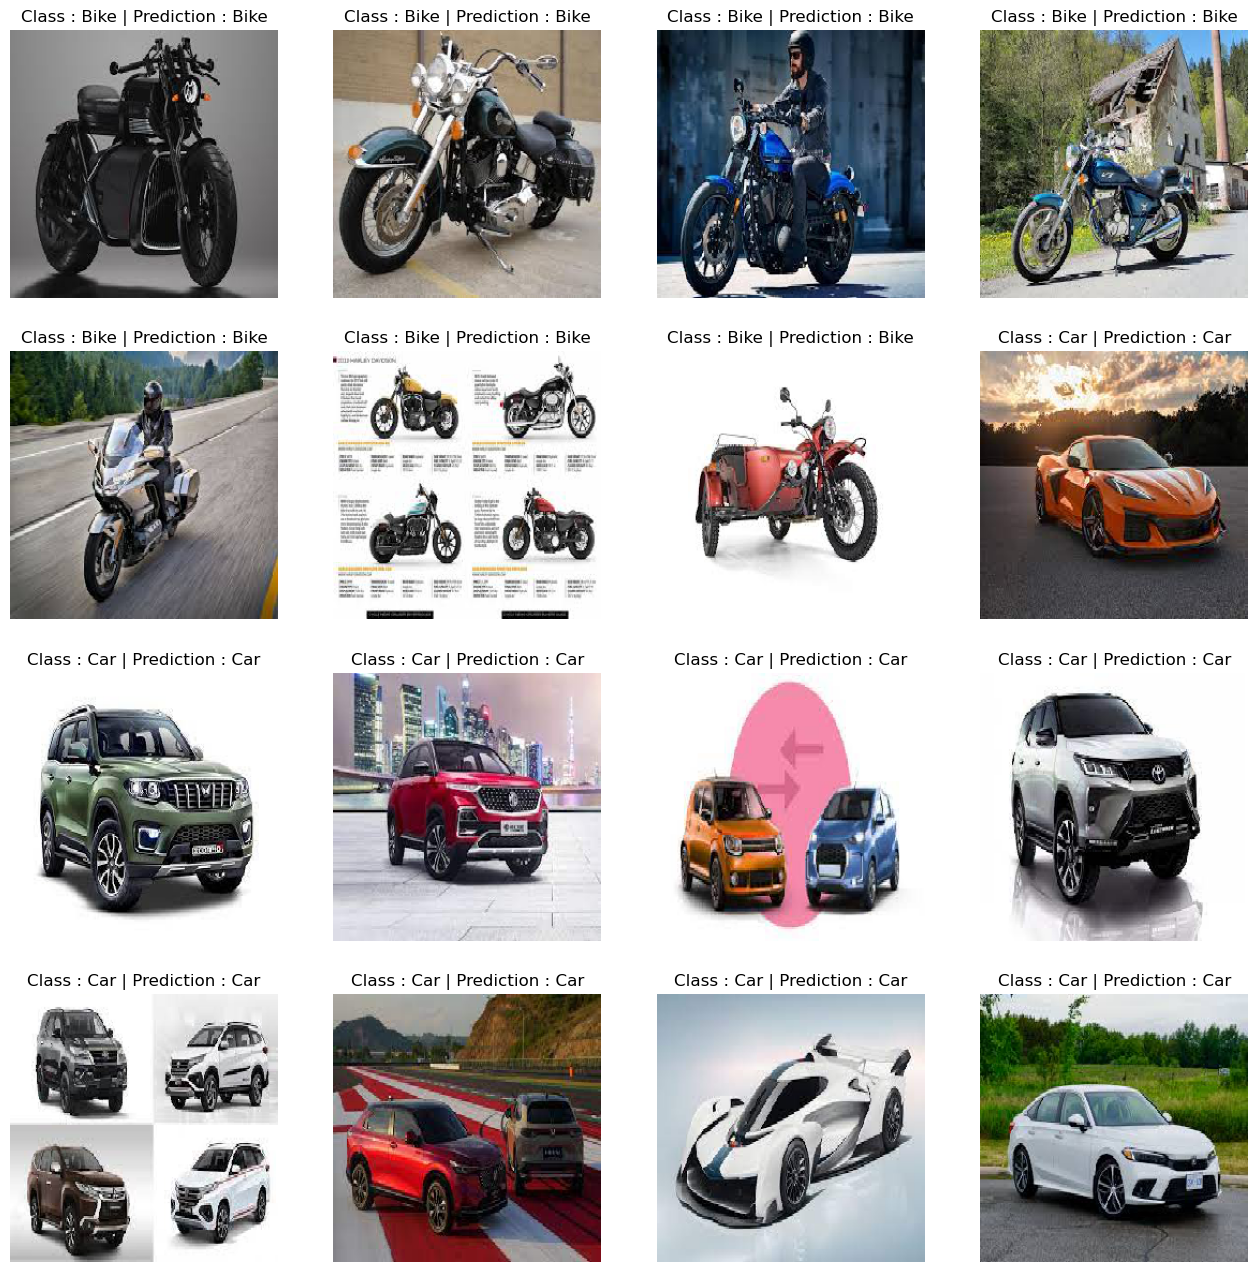

In [50]:
categories = ["Bike","Car"]

images, labels = testing_img.next()

n_rows = 4
n_cols = 4

fig = plt.gcf()
fig.set_size_inches(n_cols*4, n_rows*4)

for i, img in enumerate(images[8:24]):
    
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off') 
    plt.title(f"Class : {categories[labels[i+8].astype('uint8')]} | Prediction : {categories[test_pred[i+8].astype('uint8')]}")
    plt.imshow(img)


## Transfer learning with VGG 19

In [51]:
pre_trained_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (250,250,3))

for layer in pre_trained_model.layers:
    layer.trainable = False

print(pre_trained_model.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [53]:
model_5 = tf.keras.Sequential()
model_5.add(pre_trained_model)
model_5.add(tf.keras.layers.Flatten())
model_5.add(tf.keras.layers.Dropout(0.5))
model_5.add(tf.keras.layers.Dense(256, activation = 'relu'))
model_5.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_5.add(tf.keras.layers.Dropout(0.5))
model_5.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [54]:
model_5.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = 'accuracy')
print(model_5.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               6422784   
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                

In [55]:
## Model fitting.
start = time.time()
history = model_5.fit(x = training_img, validation_data = validation_img, epochs = epoch, callbacks = [callbacks])
end = time.time()
wait_time = np.round((end-start),2)

Epoch 1/20
80/80 [==============================] - 315s 4s/step - loss: 0.6362 - accuracy: 0.8428 - val_loss: 0.1316 - val_accuracy: 0.9525
Epoch 2/20
80/80 [==============================] - 329s 4s/step - loss: 0.1610 - accuracy: 0.9423 - val_loss: 0.3744 - val_accuracy: 0.8700
Epoch 3/20
80/80 [==============================] - 328s 4s/step - loss: 0.0862 - accuracy: 0.9705 - val_loss: 0.0681 - val_accuracy: 0.9675
Epoch 4/20
80/80 [==============================] - 329s 4s/step - loss: 0.0593 - accuracy: 0.9793 - val_loss: 0.0640 - val_accuracy: 0.9625
Epoch 5/20
80/80 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9905
Reached 98.0 % accuracy so cancelling training!
80/80 [==============================] - 338s 4s/step - loss: 0.0309 - accuracy: 0.9905 - val_loss: 0.1095 - val_accuracy: 0.9750


In [56]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

16/16 [==============================] - 26s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       200
           1       0.95      1.00      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



In [57]:
## Model on Testing Data.


testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 30 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Classification report :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [58]:
val_acc_score_model_5 = np.round(history.history['val_accuracy'][-1],2)
test_acc_score_model_5 = accuracy_score(test_labels, test_pred)

## Inserting data to dictionary.

report_df["Model"].append("VGG19")
report_df["Validation Accuracy"].append(val_acc_score_model_5)
report_df["Testing Accuracy"].append(test_acc_score_model_5)
report_df["Time"].append(wait_time)

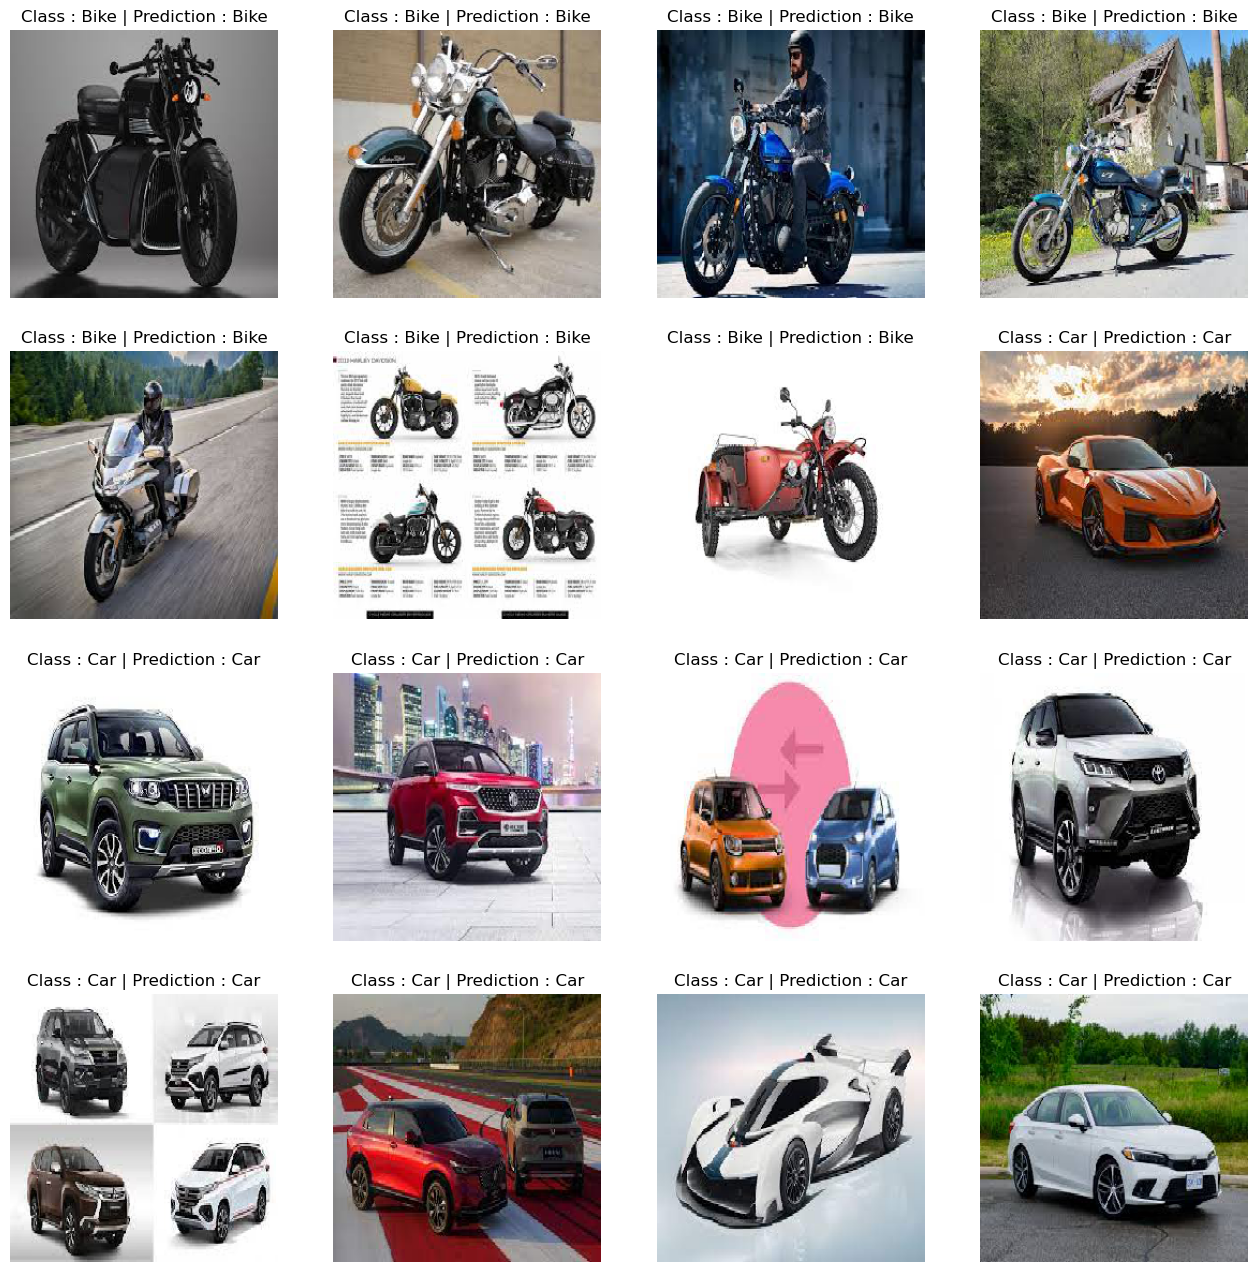

In [59]:
## Image Visualization.

categories = ["Bike","Car"]

images, labels = testing_img.next()

n_rows = 4
n_cols = 4

fig = plt.gcf()
fig.set_size_inches(n_cols*4, n_rows*4)

for i, img in enumerate(images[8:24]):
    
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off') 
    plt.title(f"Class : {categories[labels[i+8].astype('uint8')]} | Prediction : {categories[test_pred[i+8].astype('uint8')]}")
    plt.imshow(img)


In [60]:
# Define a dataframe

df_ = pd.DataFrame(report_df)
display(df_)

Model  Validation Accuracy  Testing Accuracy     Time
0     LeNet-50                 0.50               0.5   726.86
1     LeNet-50                 0.50               0.5   726.86
2      AlexNet                 0.50               0.5   929.93
3    ResNet-50                 0.87               0.9  2706.46
4  InceptionV3                 0.99               1.0   132.85
5        VGG19                 0.98               1.0  1639.17